## Simulation - Sophie Ensing

## TO DO LIST

* Nodes samen nemen
* Kortste route bepalen (inclusief wachttijd en overstaptijd)
* Andere prioriteiten: minste wachttijd en minste overstappen
* Voertuig logging verbeteren
* Overstap mogelijk maken
* Voertuig moet de juiste mensen meenemen

In [1]:
# Package(s) related to time, space and id
import datetime, time
import platform
import random
import os

# You need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy

# Spatial libraries 
import pyproj
import shapely.geometry
from simplekml import Kml, Style

# Package(s) for data handling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Tranport network analysis package
import transport_network_analysis.core as core
import transport_network_analysis.graph_module as graph_module
import transport_network_analysis.model as model

# Used for mathematical functions
import math             

# Used for making the graph to visualize our problem
import networkx as nx  

### Import data

In [2]:
# paths = nx.all_simple_paths(FG, source="CentraalStation", target="DePijp")
# for i in list(paths):
#     print(route_calculation(i, FG))

lijstje = [1, 2, 3]
lijstje.pop(0)
print(lijstje)

[2, 3]


In [3]:
# Import stations and lines from excel sheets
df1 = pd.read_csv("../../stations.csv")
df2 = pd.read_csv("../../lijnen.csv")

# Convert columns to lst type
from ast import literal_eval
df2.loc[:,'Route1'] = df2.loc[:,'Route1'].apply(lambda x: literal_eval(x))
df2.loc[:,'Route2'] = df2.loc[:,'Route2'].apply(lambda x: literal_eval(x))
df2.loc[:,'Duration'] = df2.loc[:,'Duration'].apply(lambda x: literal_eval(x))

In [4]:
# Create dictionary for all transport lines
lines = {}
durations = []

for index, row in df2.iterrows():
    lines[row["Line"]] = (row["Route1"], row["Route2"], row["Duration"])
    
edges = []
for k, v in lines.items():
    for x in range(len(v[0])):
        try:
            edges.append((v[0][x], v[0][x + 1], k, v[2][x]))
            edges.append((v[0][x + 1], v[0][x], k, v[2][x]))
        except:
            break

### Create graph

In [5]:
# Create graph
FG = nx.DiGraph()

# Create all stations and nodes
Node = type('Station', (core.Identifiable, core.Log, core.Locatable, core.HasResource, core.Station), {})
nodes = []
stations = []

for index, row in df1.iterrows():
    stations.append({"env": [],
                     "name": row["HalteNaam"],
                     "geometry": shapely.geometry.Point(row["HalteLat"], row["HalteLon"]),
                     "capacity": row["Capacity"]}) 

for station in stations:
    node = Node(**station)
    nodes.append(node)

# Create positions and add nodes to graph with right position
positions = {}

for node in nodes:
    positions[node.name] = (node.geometry.y, node.geometry.x)
    FG.add_node(node.name, geometry = node.geometry, object_type = node)

# Create all edges
for edge in edges:
    FG.add_edge(edge[0], edge[1], line = edge[2], duration = edge[3])

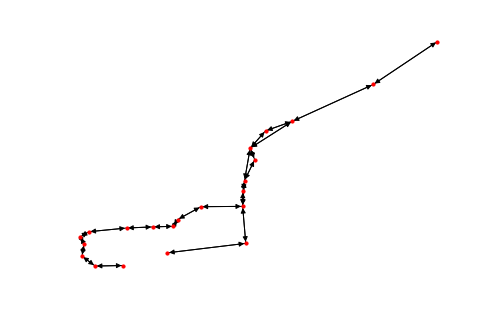

In [6]:
# Plot the network
nx.draw(FG, positions, node_size=10)
plt.show()

In [7]:
FG.node

NodeView(('Noord', 'Noorderpark', 'CentraalStation', 'Rokin', 'Vijzelgracht', 'DePijp', 'Europaplein', 'Zuid', 'Dam', 'Muntplein', 'MarieHeinekenplein', 'RoelofHartplein', 'GerritvdVeenstraat', 'Beethovenstraat', 'Minervaplein', 'Olympiaplein', 'Olympiaweg', 'OlympischStadion', 'IJsbaanpad', 'Amstelveenseweg', 'VUMedischCentrum', 'DeBoelelaanVU'))

In [8]:
# Calculate transfers and durations
def route_calculation(route, graph):
    route_info = {"lines": [], "duration": 0, "transfers": 0, "transferstations": []}
    
    for i in range(len(route) - 1):
        if route_info["lines"] != []:
            attr = FG.get_edge_data(route[i],route[i+1],default=0)
            if line != attr['line']:
                route_info["transfers"] += 1
                route_info["transferstations"].append(route[i])
                line = attr['line']
                route_info["lines"].append(line) 
        else:
            attr = FG.get_edge_data(route[i],route[i+1],default=0)
            line = attr['line']
            route_info["lines"].append(line) 

        route_info["duration"] += attr['duration']
        
    route_info["duration"] += (route_info["transfers"] * 2)
    return route_info

route_calculation(['Olympiaweg','Olympiaplein','Minervaplein','Beethovenstraat','GerritvdVeenstraat',
  'RoelofHartplein','DePijp','Vijzelgracht','Rokin','CentraalStation','Noorderpark','Noord'], FG)

{'lines': ['tram24', 'metro52'],
 'duration': 23,
 'transfers': 1,
 'transferstations': ['DePijp']}

In [9]:
iets = ['Olympiaweg','Olympiaplein','Minervaplein','Beethovenstraat','GerritvdVeenstraat',
  'RoelofHartplein','DePijp','Vijzelgracht','Rokin','CentraalStation','Noorderpark','Noord']

### Create moving parts

In [10]:
def generate_passenger(origin, destination, environment):
    """ Generate a passenger """
    Passenger = type('Passenger', (core.Identifiable, core.Routeable, core.Log), {})
    
    # Name of the object
    name = "Passenger"
    
    # Geometry of the origin
    geometry = nx.get_node_attributes(environment.FG, "object_type")[origin].geometry
    
    # Travel direction
    route = nx.dijkstra_path(environment.FG, origin, destination, weight = 'duration')
    
    transfers = 1
    
    route_info = route_calculation(route, environment.FG)
    
    return Passenger(**{"env": environment, 
                        "name": name, 
                        "route": route,
                        "route_info": route_info,
                        "transfers": route_info["transfers"],
                        "transferstations": route_info["transferstations"].copy(),
                        "duration": route_info["duration"],
                        "lines": route_info["lines"].copy()
                        })

In [11]:
def generate_metro(line, environment, linename):
    """ Generate a metro """
    Metro = type('Metro', (core.Identifiable, core.Movable, core.HasContainer, core.HasResource, 
                           core.Routeable, core.Mover), {})

    # Name of the object
    name = linename

    # Travel direction
    route = line    

    # Geometry of origin
    geometry = nx.get_node_attributes(environment.FG, "object_type")[route[0]].geometry
    
    # Maximum passengers
    capacity = 200
    
    return Metro(**{"env": environment, 
                    "name": name, 
                    "route": route, 
                    "capacity": capacity, 
                    "geometry": geometry})

### Spawn the metro trains

In [12]:
def vehicle(env, start, frequency, name, x):
    yield env.timeout(start * 60 * 60)
    while True:
        metro = generate_metro(lines[name][x], env, name)
        env.metros.append(metro)
        env.process(metro.move())
        
        # One metro every X minutes
        yield env.timeout(frequency * 60)

In [13]:
def passengers(env):
    yield env.timeout(5.5 * 60 * 60)
    while True:
        origin, destination = random.sample(env.FG.nodes, 2)

        passenger = generate_passenger(origin, destination, env)
        FG.nodes[origin]["object_type"].units.append(passenger)

        passenger.log_entry("Waiting for metro start", env.now, 0, nx.get_node_attributes(env.FG, "object_type")[origin].geometry)
        
        env.passengers.append(passenger)

        # Random arrivals of passengers with mean interarrival time of 30 seconds
        yield env.timeout(random.random() * 60)

### Run simulation

In [14]:
# Simulation start time
simulation_start = datetime.datetime(2019, 1, 1)

# Make simulation environment
env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
env.FG = FG

# For loggin
env.metros = []
env.passengers = []

# Start the simulation
env.process(vehicle(env, 5.5, 6, "metro52", 0))
env.process(vehicle(env, 5.585, 6, "metro52", 1))
env.process(vehicle(env, 6, 10, "tram24", 0))
env.process(vehicle(env, 6, 10, "tram24", 1))
env.process(passengers(env))
env.run(until = env.now + 1 * 24 * 60 * 60)

### Check results

In [24]:
# env.metros[17].log['Timestamp'][0].strftime ('%H:%M:%S')
env.metros[1].__dict__['log']

{'Message': ['Loading start',
  'Loading stop',
  'Driving from Zuid to Europaplein start',
  'Passengers: 1',
  'Driving from Zuid to Europaplein stop',
  'Driving from Europaplein to DePijp start',
  'Passengers: 1',
  'Driving from Europaplein to DePijp stop',
  'Driving from DePijp to Vijzelgracht start',
  'Passengers: 1',
  'Driving from DePijp to Vijzelgracht stop',
  'Driving from Vijzelgracht to Rokin start',
  'Passengers: 1',
  'Driving from Vijzelgracht to Rokin stop',
  'Loading start',
  'Loading stop',
  'Driving from Rokin to CentraalStation start',
  'Passengers: 2',
  'Driving from Rokin to CentraalStation stop',
  'Driving from CentraalStation to Noorderpark start',
  'Passengers: 2',
  'Driving from CentraalStation to Noorderpark stop',
  'Driving from Noorderpark to Noord start',
  'Passengers: 2',
  'Driving from Noorderpark to Noord stop'],
 'Timestamp': [datetime.datetime(2019, 1, 1, 5, 35, 6),
  datetime.datetime(2019, 1, 1, 5, 35, 6),
  datetime.datetime(2019,

In [16]:
print(datetime.datetime(2019, 1, 1, 8, 5, 3, 149775))

2019-01-01 08:05:03.149775


In [25]:
env.passengers[0].__dict__

{'env': <simpy.core.Environment at 0xa2399ab70>,
 'log': {'Message': ['Waiting for metro start'],
  'Timestamp': [datetime.datetime(2019, 1, 1, 5, 30)],
  'Value': [0],
  'Geometry': [<shapely.geometry.point.Point at 0xa183a3ba8>]},
 'route': ['RoelofHartplein', 'DePijp', 'MarieHeinekenplein'],
 'complete_path': None,
 'route_info': {'lines': ['tram24'],
  'duration': 5,
  'transfers': 0,
  'transferstations': []},
 'transfers': 0,
 'transferstations': [],
 'duration': 5,
 'lines': ['tram24'],
 'name': 'Passenger',
 'id': 'b393db1c-7001-11e9-a085-7831c1d08f6a'}

In [18]:
passengerdf = pd.DataFrame.from_dict(env.passengers[50].log)
passengerdf

,Message,Timestamp,Value,Geometry
0,Waiting for metro start,2019-01-01 05:53:27.047798,0,POINT (52.34185482 4.8913843)


In [19]:
passengerdict = {}

for i in range(len(env.passengers)):
    try:
        passengerdict[env.passengers[i].id] = {"route": env.passengers[i].route, 
                                        "origin": env.passengers[i].route[0], 
                                        "destination": env.passengers[i].route[-1], 
                                        "transfers": 0, 
                                        "waiting_time": 0, 
                                        "modes": 0, 
                                        "transferindex": 0, 
                                        "creation": env.passengers[i].log["Timestamp"][0].strftime ('%H:%M:%S'),
                                        "departure": env.passengers[i].log["Timestamp"][2].strftime ('%H:%M:%S'),
                                        "arrival": env.passengers[i].log["Timestamp"][3].strftime ('%H:%M:%S'), 
                                        "class": 0, 
                                        "date": env.passengers[i].log["Timestamp"][0].date()}
    except:
        pass
    
passengerdf = pd.DataFrame(passengerdict).T
passengerdf.to_csv("../../passengers.csv", index=True)

In [20]:
lijst = [1,2,3]
lijst.pop(0)
print(lijst)

[2, 3]


In [21]:
env.metros[8].__dict__

{'units': [],
 'env': <simpy.core.Environment at 0xa2399ab70>,
 'log': {'Message': ['Driving from Noord to Noorderpark start',
   'Passengers: 0',
   'Driving from Noord to Noorderpark stop',
   'Driving from Noorderpark to CentraalStation start',
   'Passengers: 0',
   'Driving from Noorderpark to CentraalStation stop',
   'Driving from CentraalStation to Rokin start',
   'Passengers: 0',
   'Driving from CentraalStation to Rokin stop',
   'Driving from Rokin to Vijzelgracht start',
   'Passengers: 0',
   'Driving from Rokin to Vijzelgracht stop',
   'Driving from Vijzelgracht to DePijp start',
   'Passengers: 0',
   'Driving from Vijzelgracht to DePijp stop',
   'Driving from DePijp to Europaplein start',
   'Passengers: 0',
   'Driving from DePijp to Europaplein stop',
   'Driving from Europaplein to Zuid start',
   'Passengers: 0',
   'Driving from Europaplein to Zuid stop'],
  'Timestamp': [datetime.datetime(2019, 1, 1, 5, 54),
   datetime.datetime(2019, 1, 1, 5, 54),
   datetime.

In [22]:
vehicledict = {}

for i in range(len(env.metros)):
    try:
        vehicledict[env.metros[i].id] = {"route": env.metros[i].route, 
                                        "mode": env.metros[i].name, 
                                        "departure": env.passengers[i].log["Timestamp"][0].strftime ('%H:%M:%S'),
                                        "arrival": env.passengers[i].log["Timestamp"][-1].strftime ('%H:%M:%S'), 
                                        "date": env.passengers[i].log["Timestamp"][0].date()}
    except:
        pass
    
vehicledf = pd.DataFrame(vehicledict).T
vehicledf.to_csv("../../vehicles.csv", index=True)

In [23]:
vehicledf

,arrival,date,departure,mode,route
b39387d4-7001-11e9-84e0-7831c1d08f6a,05:30:00,2019-01-01,05:30:00,metro52,"[Noord, Noorderpark, CentraalStation, Rokin, V..."
b394ab34-7001-11e9-889a-7831c1d08f6a,06:26:00,2019-01-01,05:30:13,metro52,"[Zuid, Europaplein, DePijp, Vijzelgracht, Roki..."
b3952788-7001-11e9-b7f4-7831c1d08f6a,05:30:53,2019-01-01,05:30:53,metro52,"[Noord, Noorderpark, CentraalStation, Rokin, V..."
b3966fba-7001-11e9-9c63-7831c1d08f6a,06:14:00,2019-01-01,05:30:55,metro52,"[Zuid, Europaplein, DePijp, Vijzelgracht, Roki..."
b39700c6-7001-11e9-9789-7831c1d08f6a,06:07:00,2019-01-01,05:31:33,metro52,"[Noord, Noorderpark, CentraalStation, Rokin, V..."
b398a908-7001-11e9-8db0-7831c1d08f6a,06:03:15,2019-01-01,05:31:38,metro52,"[Zuid, Europaplein, DePijp, Vijzelgracht, Roki..."
b3992b3a-7001-11e9-a99c-7831c1d08f6a,06:00:00,2019-01-01,05:31:46,metro52,"[Noord, Noorderpark, CentraalStation, Rokin, V..."
b39a6cb6-7001-11e9-b068-7831c1d08f6a,06:10:30,2019-01-01,05:31:53,metro52,"[Zuid, Europaplein, DePijp, Vijzelgracht, Roki..."
b39ac6ca-7001-11e9-a7c3-7831c1d08f6a,05:36:00,2019-01-01,05:32:09,metro52,"[Noord, Noorderpark, CentraalStation, Rokin, V..."
b39c2a42-7001-11e9-98b9-7831c1d08f6a,06:05:45,2019-01-01,05:32:21,metro52,"[Zuid, Europaplein, DePijp, Vijzelgracht, Roki..."
